# Notebook to prepare the Eigenstrat of D. Reich
Idea: Keep it as Code Sequence, so I can readily update in case data gets updated

### Overview of structure of this notebook

1. Download the Data
2. Test 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec
import socket
import os as os
import sys as sys
import multiprocessing as mp
import matplotlib.colors as cls
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

midway2-0401.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


In [2]:
# Download the Data
def download_eigenstrat():
    download_link = "https://reichdata.hms.harvard.edu/pub/datasets/amh_repo/curated_releases/V37/V37.2/SHARE/public.dir/v37.2.1240K.tar"
    file_name = os.path.basename(download_link)  # Get the File Name
    local_folder ="./Data/ReichLabEigenstrat/Raw/"
    download_path = os.path.join(local_folder, file_name) 

    if not os.path.exists(local_folder):
        print(f"Creating {local_folder}...")
        os.makedirs(local_folder)

    ### Run the Shell Download
    !wget -P $download_path $download_link 
    
def unpack_eigenstrat():
    ### Untar the file
    !tar -xf $download_path -C $local_folder
    !rm $download_path  # Delete the tar File

In [2]:
#download_eigenstrat()
#unpack_eigenstrat()

# Analyze the Reich Meta Data
Standalone

### Load and process meta data

In [100]:
### Load Metafile from D. Reich:
def load_eigenstrat_anno(path="./Data/ReichLabEigenstrat/Raw/v37.2.1240K.clean4.anno",                   
                         id_col='Instance ID ("_all" means includes a mix of UDG-treated and non-UDG-treated; "_published" distinguishes a published sample for a still-unpublished higher quality version)',
                         anc_only=True):
    """Load annotated Eigenstrat (from D. Reich's group)"""
    df_anno = pd.read_csv(path, sep="\t", engine="python")
    #coverage = pd.to_numeric(df_anno["Coverage"], errors='coerce')
    coverage = pd.to_numeric(df_anno["Coverage on autosomal targets"], errors='coerce')
    df_anno["coverage"]=coverage

    # Convert the Ages as well
    ages = df_anno["Average of 95.4% date range in calBP (defined as 1950 CE)  "]
    df_anno["ages"] = pd.to_numeric(ages, errors='coerce')  #

    ### Convert Longitude and Latitude
    lat = df_anno["Lat."]
    lon = df_anno["Long."]
    df_anno["lat"] = pd.to_numeric(lat, errors='coerce')
    df_anno["lon"] = pd.to_numeric(lon, errors='coerce')
    df_anno["iid"] = df_anno[id_col]   # "Instance ID"
    
    df_anc = df_anno[df_anno["ages"]>0]

    print(f"Loaded {len(df_anc)} / {len(df_anno)} ancient Indivdiuals.")
    print(f"Without Coverage: {np.sum(np.isnan(coverage))}")
    if anc_only:
        df_anno=df_anc
    return df_anno

def produce_meta_csv(df_anc, save_path = "./Data/ReichLabEigenstrat/Raw/meta.csv",
                     ass_col='ASSESSMENT (Xcontam listed if |Z|>2 standard errors from zero: 0.02-0.05="QUESTIONABLE", >0.05="QUESTIONABLE_CRITICAL" or "FAIL") (mtcontam 97.5th percentile estimates listed if coverage >2: <0.8 is "QUESTIONABLE_CRITICAL", 0.8-0.95 is "QUESTIONABLE", and 0.95-0.98 is recorded but "PASS", gets overriden by ANGSD)',
                     group_col='Group_ID (format convention which we try to adhere to is "Country_<Geographic.Region_<Geographic.Subregion_>><Archaeological.Period.Or.DateBP_<Alternative.Archaeological.Period_>><Archaeological.Culture_<Alternative.Archaeological.Culture>><genetic.subgrouping.index.if.necessary_><"o_"sometimes.with.additional.detail.if.an.outlier><additional.suffix.especially.relative.status.if.we.recommend.removing.from.main.analysis.grouping><"contam_".if.contaminated><"lc_".if.<15000.SNPs.on.autosomal.targets><".SG".or.".DG".if.shotgun.data>; HG=hunter-gatherer, N=Neolithic, C=Chalcolithic/CopperAge, BA=BronzeAge, IA=IronAge, E=Early, M=Middle, L=Late, A=Antiquity)',
                     cov_col = "Coverage on autosomal targets",
                     snps_cov_col = "SNPs hit on autosomal targets"
                     ):
    """Produce a formatted meta .csv in my style, to streamline
    further processing (and use same machinery)"""
    ### Transfer the include_alt column
    asmts = df_anc[ass_col]
    good = asmts.str.startswith("PASS") # the ones that pass
    bad = asmts.str.startswith("QUES")  # The ones that are "questionable" contamination
    
    assert(len(asmts)==np.sum(good) + np.sum(bad))

    include = np.zeros(len(asmts), dtype="int8")
    include[good] = 1
    df_anc[ass_col] = include # Save column

    df_save = df_anc[["iid", "lat", "lon", "ages", "Publication", group_col, cov_col, snps_cov_col, ass_col]]
    df_save.columns =["iid", "lat", "lon", "age", "study", "clst", "mean_cov", "n_cov_snp", "include_alt"]  # Rename to standard columns
    if len(save_path)>0:
        df_save.to_csv(save_path, index=False)
        print(f"Saved {len(df_save)} rows to {save_path}")
    return df_save

# Prepare new Meta-File with standardized columns
Run df_anc creation above, and then here save it

In [102]:
df_anc = load_eigenstrat_anno(path="./Data/ReichLabEigenstrat/Raw.v42.4/v42.4.1240K.anno")
df_save = produce_meta_csv(df_anc, save_path="./Data/ReichLabEigenstrat/Raw/meta.v42.csv")

Loaded 3723 / 6676 ancient Indivdiuals.
Without Coverage: 2543
Saved 3723 rows to ./Data/ReichLabEigenstrat/Raw/meta.v42.csv


### Load Marcus Data

In [30]:
meta_path = "./Data/Marcus2019_1240k/meta_rev_final.csv"
meta_df = pd.read_csv(meta_path)  # Load the Meta File
meta_df.columns

Index(['iid', 'label', 'lat', 'lon', 'x_contam', 'mt_contam', 'age', 'study',
       'clst_alt', 'period_alt', 'include_alt', 'clst', 'mean_cov', 'med_cov',
       'n_cov_snp_read', 'full_iid', 'n_cov_snp'],
      dtype='object')

### Histogram of ReichAll Ages

In [31]:
### Extract only the non-Moderns: 
df_anc = load_eigenstrat_anno(path="./Data/ReichLabEigenstrat/Raw.v42.4/v42.4.1240K.anno")
age_okay = (df_anc["ages"]>0) & (df_anc["ages"]<20000)
np.sum(age_okay)

Loaded 3723 / 6676 ancient Indivdiuals.
Without Coverage: 2543


3678

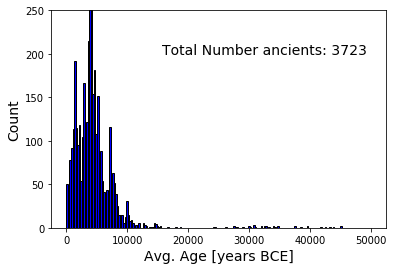

In [32]:
### Interesting Columns: 
#"SNPs hit on autosomes", "Coverage"
#Average of 95.4% date range in calBP (defined as 1950 CE)  
fs = 14
bins = np.linspace(0, 5e4, 200)

plt.figure(figsize=(6,4))
ax=plt.gca()
plt.hist(df_anc["ages"], color="blue", ec="k", bins=bins)
#ax.axvline(0.5, color="red", lw=2)
plt.ylim([0,250])
plt.xlabel("Avg. Age [years BCE]", fontsize=fs)
plt.ylabel("Count", fontsize=fs)
ax.text(x=0.33, y=0.8, 
        s=f"Total Number ancients: {len(df_anc)}", transform=ax.transAxes, fontsize=fs)
plt.show()

In [33]:
### Produce exact cumulatative density function:
x_cdf = np.sort(df_anc["coverage"])
y_cdf = np.array(range(len(x_cdf)))/len(x_cdf)

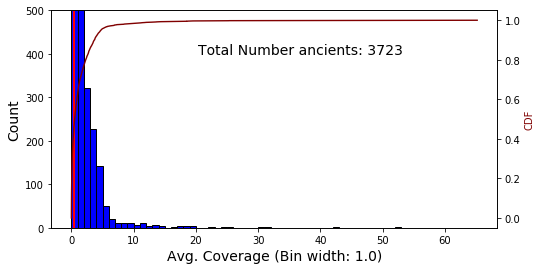

In [34]:
### Interesting Columns: 
#"SNPs hit on autosomes", "Coverage"
#Average of 95.4% date range in calBP (defined as 1950 CE)  
fs = 14
bins = np.linspace(0, 60, 61)

plt.figure(figsize=(8,4))
ax=plt.gca()
plt.hist(df_anc["coverage"], color="blue", ec="k", bins=bins)
ax.axvline(0.5, color="red", lw=2)
ax.set_ylim([0,500])
#plt.xlim([0,30])
plt.xlabel(f"Avg. Coverage (Bin width: {bins[1]-bins[0]:.1f})", fontsize=fs)
plt.ylabel("Count", fontsize=fs)
ax.text(x=0.33, y=0.8, 
        s=f"Total Number ancients: {len(df_anc)}", transform=ax.transAxes, fontsize=fs)

### 
ax2 = ax.twinx()
ax2.plot(x_cdf, y_cdf, c="maroon", lw=1.4)
ax2.set_ylabel("CDF", color="maroon")
plt.show()

Saved to ./figures/poster_probgen19/samples_cov.png


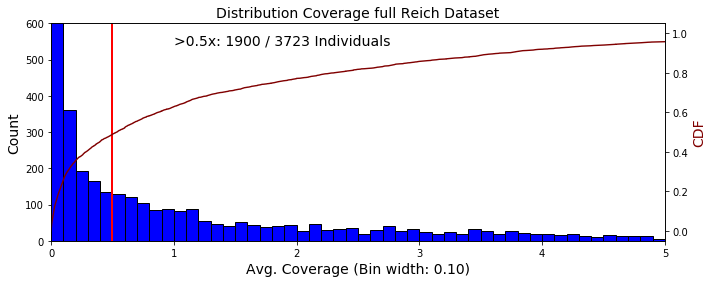

In [35]:
bins = np.linspace(0, 10, 101)
fs = 14
plt.figure(figsize=(11,4))
ax=plt.gca()
ax.axvline(0.5, color="red", lw=2)

plt.hist(df_anc["coverage"], color="blue", ec="k", bins=bins)
ax.set_ylim([0, 600])
plt.xlabel(f"Avg. Coverage (Bin width: {bins[1]-bins[0]:.2f})", fontsize=fs)
plt.ylabel("Count", fontsize=fs)

covs = df_anc["coverage"]
ax.text(x=0.2, y=0.9, s=f">0.5x: {np.sum(covs>0.5)} / {len(covs)} Individuals", 
        transform=ax.transAxes, fontsize=fs)

ax2 = ax.twinx()
ax2.plot(x_cdf, y_cdf, c="maroon", lw=1.4)
ax2.set_ylabel("CDF", color="maroon", fontsize=fs)

plt.xlim(0,5)
plt.title("Distribution Coverage full Reich Dataset", fontsize=fs)
savepath="./figures/poster_probgen19/samples_cov.png"
plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=200)
print(f"Saved to {savepath}")

plt.show()

In [ ]:
### Produce exact cumulatative density function:
y = df_anc["SNPs hit on autosomes"].values

x_cdf = np.sort(y)
y_cdf = np.array(range(len(x_cdf)))/len(x_cdf)

bins = np.linspace(0, 1.2e6, 121)
fs = 14
plt.figure(figsize=(8,4))
ax=plt.gca()
ax.axvline(5e5, color="red", lw=2)

plt.hist(y, color="blue", ec="k", bins=bins)
ax.set_ylim([0,100])
plt.xlabel(f"#SNPs covered (Bin width: {bins[1]-bins[0]:.0f})", fontsize=fs)
plt.ylabel("Count", fontsize=fs)

covs = df_anc["coverage"]
ax.text(x=0.01, y=0.9, s=f">500k: {np.sum(y>5e5)} / {len(y)} Inds.", 
        transform=ax.transAxes, fontsize=fs)

ax2 = ax.twinx()
ax2.plot(x_cdf, y_cdf, c="maroon", lw=1.4)
ax2.set_ylabel("CDF", color="maroon", fontsize=fs)

#plt.xlim(0,5)
plt.title("Distribution #SNPs covered full Reich Dataset", fontsize=fs)
plt.show()

### Plot all ReichAll Samples on a world Map

In [46]:
def plot_world_map(df_plot, fs = 18, c_map = "viridis_r",
                   p_range= (0, 12000), figsize=(18,12), dpi=200,
                   savepath = "./figures_test/reich_eigenstrat_map_v42.png"):
    """"""
    cmap0 = cm.get_cmap(c_map)
    norm0 = plt.Normalize(p_range[0], vmax=p_range[1])  # Normalize to age BCE

    normc = cls.Normalize(vmin = p_range[0]/1e3, vmax = p_range[1]/1e3) # For the Color Bar
    colors = [cmap0(norm0(i)) for i in df_anc["ages"].values]
    fig = plt.figure(figsize=figsize)
    ax=fig.add_axes([0.1,0.1,0.8,0.8])

    #m = Basemap(projection='cyl',llcrnrlat=-60,urcrnrlat=85, 
    #                llcrnrlon=-180,urcrnrlon=180,resolution='c')
    m = Basemap(projection='moll', lat_0=0, lon_0=0)
    m.drawcoastlines()
    #m.drawparallels(np.arange(-90,90,30),labels=[1,1,0,1], fontsize=8)
    #m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1], rotation=45, fontsize=8)
    #m.etopo(scale=0.5, alpha=0.4)  # if topological map
    m.drawcoastlines(color='gray', zorder=0)
    m.drawcountries(color="dimgray")
    #m.drawstates()

    plt.title(f"Distribution of n={len(df_plot)} aDNA samples >0.5x worldwide", fontsize=fs)
    m.scatter(df_plot["lon"].values, df_plot["lat"].values, latlon=True, cmap=cmap0, norm=norm0,
              c=df_plot["ages"].values, alpha=0.8, s=25, edgecolors='k', linewidths=0.3)

    plt.colorbar(label="Age [ky BP]", shrink=0.5)
    
    if len(savepath)>0:
        fig.savefig(savepath, dpi=dpi, bbox_inches = 'tight', pad_inches = 0)

    plt.show()

/home/hringbauer/.local/lib/python3.7/site-packages/mpl_toolkits/basemap/__init__.py:4786: RuntimeWarning: invalid value encountered in greater
  lonsin = np.where(lonsin > lon_0+180, lonsin-360 ,lonsin)
/home/hringbauer/.local/lib/python3.7/site-packages/mpl_toolkits/basemap/__init__.py:4787: RuntimeWarning: invalid value encountered in less
  lonsin = np.where(lonsin < lon_0-180, lonsin+360 ,lonsin)
/home/hringbauer/.local/lib/python3.7/site-packages/mpl_toolkits/basemap/__init__.py:4793: RuntimeWarning: invalid value encountered in greater_equal
  itemindex = len(lonsin)-np.where(londiff>=thresh)[0]
/home/hringbauer/.local/lib/python3.7/site-packages/mpl_toolkits/basemap/__init__.py:4824: RuntimeWarning: invalid value encountered in less
  mask = np.logical_or(lonsin<lon_0-180,lonsin>lon_0+180)
/home/hringbauer/.local/lib/python3.7/site-packages/mpl_toolkits/basemap/__init__.py:4824: RuntimeWarning: invalid value encountered in greater
  mask = np.logical_or(lonsin<lon_0-180,lonsin>

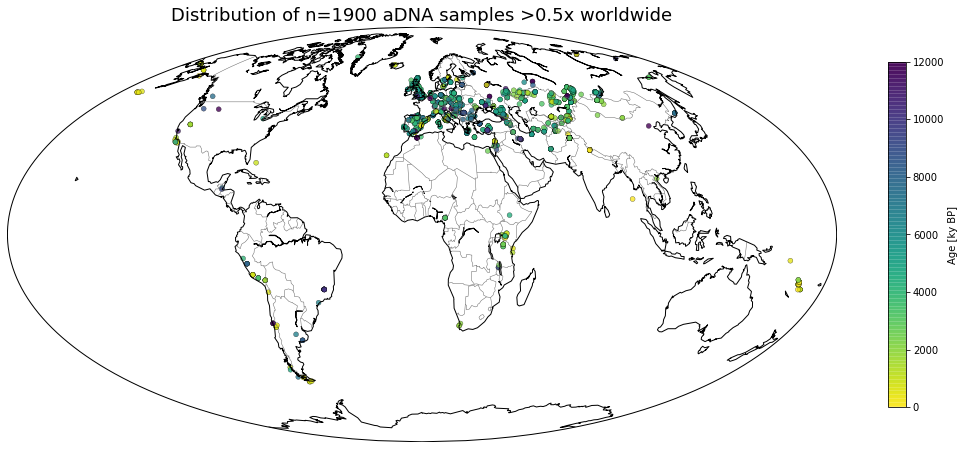

In [47]:
### Extract only the non-Moderns: 
df_anc = load_eigenstrat_anno(path = "./Data/ReichLabEigenstrat/Raw.v42.4/v42.4.1240K.anno")
age_okay = (df_anc["ages"]>0) & (df_anc["ages"]<20000)
np.sum(age_okay)

df_plot = df_anc[df_anc["coverage"]>0.5]
len(df_plot)

plot_world_map(df_plot)

### Plot Difference between old and new Sample

In [103]:
#meta_path = "./Data/ReichLabEigenstrat/Raw/meta.v42.csv"
meta_path = "./Data/ReichLabEigenstrat/Raw.v42.4/v42.4.1240K.anno"
df_anc = load_eigenstrat_anno(path = meta_path)
#df_anc = pd.read_csv(meta_path, sep="\t")
age_okay = (df_anc["ages"]>0) & (df_anc["ages"]<20000)
np.sum(age_okay)
df_anc = df_anc[age_okay]

df_plot = df_anc[df_anc["coverage"]>0.2]

### Check what is in the old Map
df_old = pd.read_csv("./Data/ReichLabEigenstrat/Raw/v37.2.1240K.clean4.anno", sep="\t")

### Check if new IIDs in there
idx = df_plot["iid"].isin(df_old["Instance ID"].values)
print(f"Found {np.sum(idx)} IIDs out of {len(idx)}")
df_plot2 = df_plot[~idx].copy()
df_plot3 = df_plot[idx].copy()
#df_plot2

Loaded 3723 / 6676 ancient Indivdiuals.
Without Coverage: 2543
Found 1278 IIDs out of 2365


/home/hringbauer/.local/lib/python3.7/site-packages/mpl_toolkits/basemap/__init__.py:4786: RuntimeWarning: invalid value encountered in greater
  lonsin = np.where(lonsin > lon_0+180, lonsin-360 ,lonsin)
/home/hringbauer/.local/lib/python3.7/site-packages/mpl_toolkits/basemap/__init__.py:4787: RuntimeWarning: invalid value encountered in less
  lonsin = np.where(lonsin < lon_0-180, lonsin+360 ,lonsin)
/home/hringbauer/.local/lib/python3.7/site-packages/mpl_toolkits/basemap/__init__.py:4793: RuntimeWarning: invalid value encountered in greater_equal
  itemindex = len(lonsin)-np.where(londiff>=thresh)[0]
/home/hringbauer/.local/lib/python3.7/site-packages/mpl_toolkits/basemap/__init__.py:4824: RuntimeWarning: invalid value encountered in less
  mask = np.logical_or(lonsin<lon_0-180,lonsin>lon_0+180)
/home/hringbauer/.local/lib/python3.7/site-packages/mpl_toolkits/basemap/__init__.py:4824: RuntimeWarning: invalid value encountered in greater
  mask = np.logical_or(lonsin<lon_0-180,lonsin>

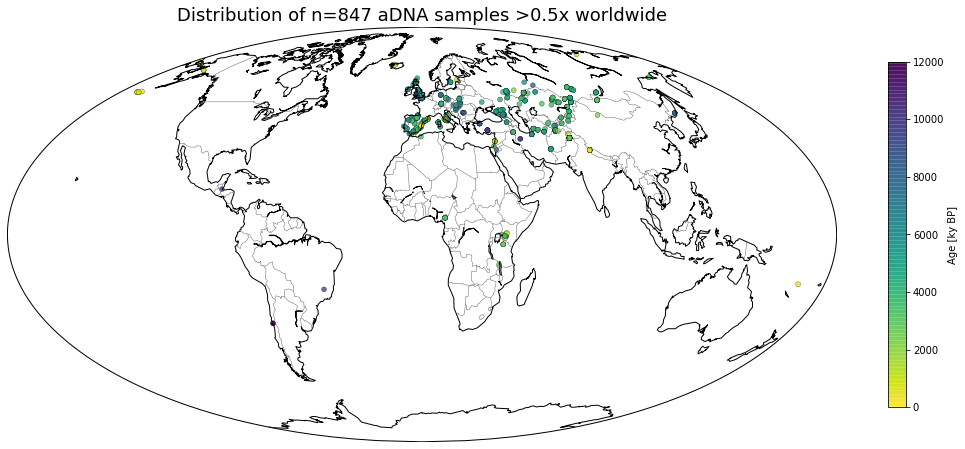

In [94]:
plot_world_map(df_plot2)

### Save Dataset of new Individuals

In [104]:
df_save = produce_meta_csv(df_plot2, 
                           save_path = "./Data/ReichLabEigenstrat/Raw/meta.v42_additional.csv")

Saved 1087 rows to ./Data/ReichLabEigenstrat/Raw/meta.v42_additional.csv


In [105]:
df_save = produce_meta_csv(df_plot3, 
                           save_path = "./Data/ReichLabEigenstrat/Raw/meta.v42_core.csv")

Saved 1278 rows to ./Data/ReichLabEigenstrat/Raw/meta.v42_core.csv


# Test Intersection with Sardinia

In [67]:
meta_path = "./Data/Marcus2019_1240k/meta_rev_unique_ids.csv"
#meta_path = "./Data/ReichLabEigenstrat/Raw/meta.v42.csv"
meta_df = pd.read_csv(meta_path)
df_anc_m = meta_df[:1057]         # 1098 is all ancients

In [68]:
df_merge = pd.merge(df_anc_m, df_anc[["iid","ages","coverage"]], on="iid")
print(f"Found {len(df_merge)} Samples in both datasets")

Found 1057 Samples in both datasets


In [69]:
diff_age = df_merge["age"] - df_merge["ages"]
df_merge[np.abs(diff_age)>500]

,iid,lat,lon,age,study,clst,mean_cov,n_cov_snp,include_alt,ages,coverage


In [7]:
np.corrcoef(df_merge["mean_cov"].values, df_merge["coverage"].values)

array([[1.        , 0.98032728],
       [0.98032728, 1.        ]])

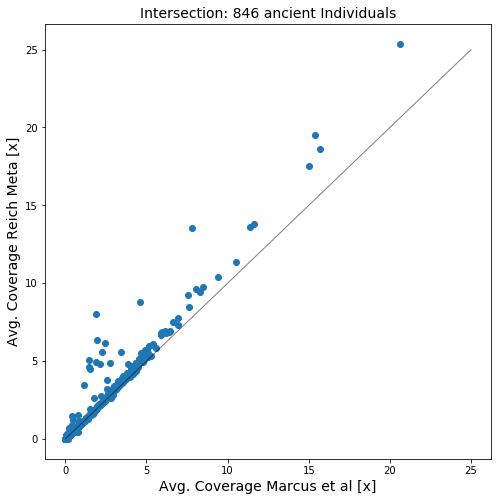

In [8]:
plt.figure(figsize=(8,8))
fs=14
plt.scatter(df_merge["mean_cov"], df_merge["coverage"])
plt.xlabel("Avg. Coverage Marcus et al [x]", fontsize=fs)
plt.ylabel("Avg. Coverage Reich Meta [x]", fontsize=fs)
plt.plot([0,25],[0,25], lw=1, alpha=0.5, c="k")
plt.title(f"Intersection: {len(df_merge)} ancient Individuals", fontsize=fs)
plt.show()

In [12]:
df_merge[(df_merge["coverage"]>6) & (df_merge["mean_cov"]<3)]

,iid,label,lat,lon,x_contam,mt_contam,age,study,clst_alt,period_alt,include_alt,clst,mean_cov,med_cov,n_cov_snp_read,full_iid,n_cov_snp,ages,coverage
209,I2495,Anatolia_BronzeAge,37.917740,30.708390,NaN,NaN,4376.5,Mathieson et al. 2018,Anatolia,BA,1,Anatolia-BA,1.912487,1.0,612103.0,I2495,612103,4377.0,8.01713
656,I2366,Baden_LCA,47.620940,19.044940,NaN,NaN,5092.5,Lipson et al. 2017,Baden,LCA,1,Balkans-BA,1.974700,1.0,772215.0,I2366,772215,5093.0,6.37800
680,I2794,Koros_EN,47.191612,20.402331,NaN,NaN,7573.5,Lipson et al. 2017,Koros,EN,1,Balkans-MNCA,2.438818,2.0,808283.0,I2794,808283,7574.0,6.16200


In [13]:
len(df_merge)

846

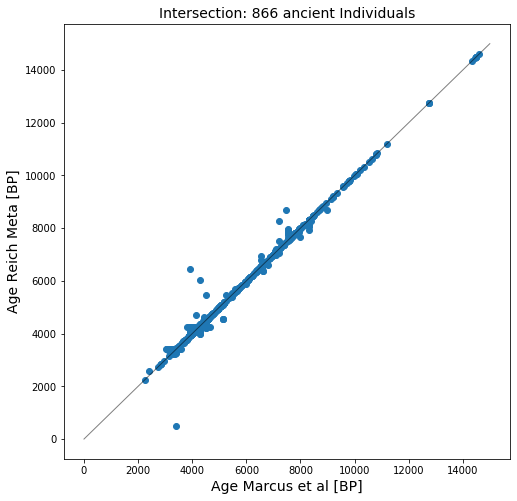

In [42]:
plt.figure(figsize=(8,8))
fs=14
plt.scatter(df_merge["age"], df_merge["ages"])
plt.xlabel("Age Marcus et al [BP]", fontsize=fs)
plt.ylabel("Age Reich Meta [BP]", fontsize=fs)
plt.plot([0,15000],[0,15000], lw=1, alpha=0.5, c="k")
plt.title(f"Intersection: {len(df_merge)} ancient Individuals", fontsize=fs)
plt.show()

In [7]:
np.sum(df_merge["mean_cov"]>0.5)

514

# Area 51
Test code here

In [4]:
download_link = "https://reichdata.hms.harvard.edu/pub/datasets/amh_repo/curated_releases/V37/V37.2/SHARE/public.dir/v37.2.1240K.tar"
os.path.basename(download_link)

'v37.2.1240K.tar'

In [8]:
file_name

'v37.2.1240K.tar'